In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rand
from IPython.core.display import HTML
%matplotlib inline

In [3]:
# read in data
thievery = pd.read_csv("stolen_art_new.csv")
thievery.head()

,title,maker,crimeCategory,primaryMaterial,numMaterials,century,size,units
0,Shakti II,Benjamin Creme,print,lithograph,1,21st,4.227396,square feet
1,Seated Woman,Raphael Soyer,drawing-watercolour,other,2,other,4.276389,square feet
2,Magda and Raymond,Walter Pach,paintings,oil,2,20th,3.334000,square feet
3,Jan,Edna Hibel,print,lithograph,1,20th,NaN,NaN
4,Tiger painting,Michael Ward,paintings,watercolor,1,20th,18.335000,square feet


## 1. Distribution of Sizes

### With outliers

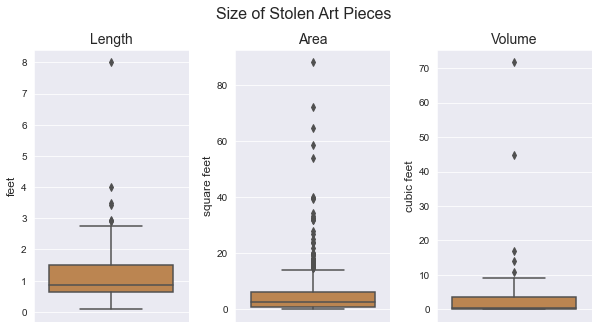

In [4]:
# datasets filtered by dimension
one = thievery[thievery['units'] == "feet"]['size']
two = thievery[thievery['units'] == "square feet"]['size']
three = thievery[thievery['units'] == "cubic feet"]['size']

# function that will plot sizes for each dimension
def sizeplot(dims, title, col, dist = 1):
    # distribution of size of pieces for each dimension
    sns.set_style("darkgrid")

    # create three subplots, one for each dimension
    fig, axes = plt.subplots(1,3)
    fig.set(figwidth=10, figheight=5)

    # boxplots for each (plotting on separate y-axis scales)
    sns.boxplot(y=dims[0], ax=axes[0], color=col)
    sns.boxplot(y=dims[1], ax=axes[1], color=col)
    sns.boxplot(y=dims[2], ax=axes[2], color=col)

    # set titles of axes
    fig.suptitle(title, fontsize='16', y=dist)
    axes[0].set_title('Length', fontsize='14')
    axes[1].set_title('Area', fontsize='14')
    axes[2].set_title('Volume', fontsize='14')
    axes[0].set_ylabel('feet', fontsize='12')
    axes[1].set_ylabel('square feet', fontsize='12')
    axes[2].set_ylabel('cubic feet', fontsize='12')

    # put more horizontal space between plots
    fig.subplots_adjust(wspace=0.3)
    plt.show()

sizeplot([one, two, three], 'Size of Stolen Art Pieces', 'peru')

### Without most outliers

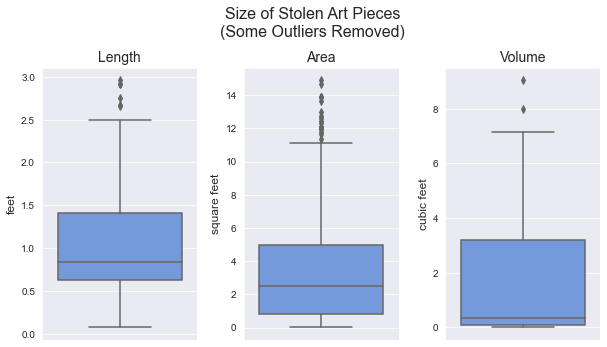

In [5]:
# same process as before, just with some outliers removed
sizeplot([one[one < 3], two[two < 15], three[three < 10]], 
'Size of Stolen Art Pieces\n(Some Outliers Removed)', "cornflowerblue", 1.05)


### Table of most extreme outliers

In [6]:
outliers = thievery[((thievery['units'] == 'feet') & (thievery['size'] > 5)) | ((thievery['units'] == 'square feet') & (thievery['size'] > 40)) | ((thievery['units'] == 'cubic feet') & (thievery['size'] > 40))].sort_values(by=['units','size'])
display(HTML(outliers.to_html()))

,title,maker,crimeCategory,primaryMaterial,numMaterials,century,size,units
950,Philad Long Rifle,H. Deringer Philad,other,other,4,19th,44.913000,cubic feet
666,Garden Elements,Isamu Noguchi,sculpture,bronze,2,20th,71.671040,cubic feet
953,Caduceus | Staff of Asclepius,Mary Ann Lohman,sculpture,other,1,20th,8.000000,feet
341,Stations of the Cross - 8,Ben Stahl,paintings,NaN,0,20th,54.000000,square feet
647,Venice - et cum spiritu tuo,Claire Khalil,paintings,oil,3,20th,58.700611,square feet
727,Country Scenes,NaN,textiles,NaN,0,17th,64.730639,square feet
888,Renaissance Tapestry,NaN,textiles,silk,1,19th,72.222111,square feet
745,The Story of Anthony and Cleopatra,NaN,textiles,NaN,0,16th,88.000000,square feet


### Fill in outliers with random value from IQR

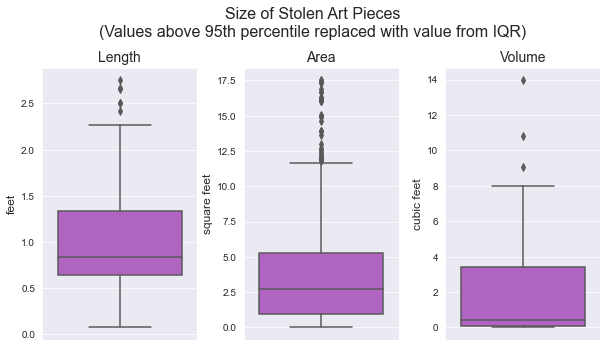

In [54]:
# Fill outliers with some value within the IQR
def fill_outliers(dim):
    cutoff = dim.quantile(0.95)
    q1 = dim.quantile(0.25)
    q3 = dim.quantile(0.75)
    return [round(rand.uniform(q1,q3),3) if i > cutoff else i for i in dim]

one_filled = fill_outliers(one)
two_filled = fill_outliers(two)
three_filled = fill_outliers(three)

sizeplot([one_filled, two_filled, three_filled], 
'Size of Stolen Art Pieces\n(Values above 95th percentile replaced with value from IQR)', "mediumorchid", 1.05)

### Comparison of mean, median and standard deviation

In [56]:
def summarize(cols):
    all = pd.concat(cols, axis=1)
    all.set_axis(['length','area','volume'], axis=1, inplace=True)
    return round(all.agg(['median','mean','std']), 3)

with_outliers = summarize([one, two, three])
without_outliers = summarize([one[one < 3], two[two < 15], three[three < 10]])
filled_outliers = summarize([pd.DataFrame(one_filled), pd.DataFrame(two_filled), pd.DataFrame(three_filled)])

pd.concat([with_outliers, without_outliers, filled_outliers], axis=1, keys=['With Outliers', 'Without Outliers', 'Filled Outliers'])

With Outliers                Without Outliers                \
              length   area  volume           length   area volume   
median         0.867  2.806   0.516            0.833  2.500  0.346   
mean           1.175  5.364   4.568            1.068  3.479  1.746   
std            0.955  8.426  11.665            0.660  3.302  2.451   

       Filled Outliers                
                length   area volume  
median           0.833  2.750  0.438  
mean             1.023  3.915  2.170  
std              0.589  3.916  3.132

## 2. Top Artists (no, this isn't suddenly Spotify)

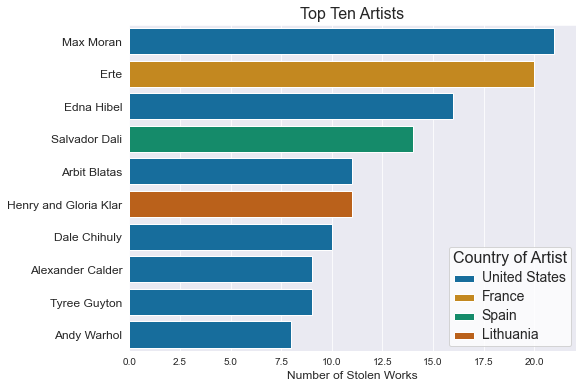

In [8]:
sns.set_style("darkgrid")
sns.set_palette("colorblind")
plt.figure(figsize=(8,6))

# set list of top artists (only individuals) and number of stolen paintings for each
# dict(thievery['maker'].value_counts())
artists = ['Max Moran', 'Erte', 'Edna Hibel', 'Salvador Dali', 'Henry and Gloria Klar', 'Arbit Blatas', 'Dale Chihuly', 'Tyree Guyton', 'Alexander Calder', 'Andy Warhol']
top_artists = thievery[thievery['maker'].isin(artists)]['maker'].value_counts().to_frame().reset_index()
# manually include country of each top artist
top_artists['country'] = ['United States', 'France', 'United States', 'Spain', 'United States', 'Lithuania', 'United States', 'United States', 'United States', 'United States']

# barplot of top artists, colored by country
ax = sns.barplot(y = 'index', x = 'maker', hue='country', data=top_artists, dodge=False)
ax.set_ylabel("")
ax.set_xlabel("Number of Stolen Works", fontsize='12')
ax.set_title("Top Ten Artists", fontsize='16')
legend = plt.legend(title='Country of Artist')
plt.setp(ax.get_legend().get_texts(), fontsize='14')
plt.setp(ax.get_legend().get_title(), fontsize='16')
plt.setp(ax.get_yticklabels(), fontsize='12')
legend.get_frame().set_facecolor('white')
plt.show()


## 3. Stolen Works by Century
I used a barplot instead of a lineplot because this categorizes stolen pieces by the century they were created. It doesn't provide a timeline of when pieces were stolen or when certain centuries were more "popular" among art thieves

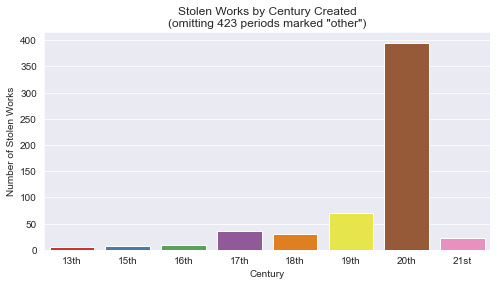

In [9]:
# manually order centuries chronologically and get n(works) for each
century_ordered = ['13th', '15th', '16th', '17th', '18th', '19th', '20th', '21st']
counts = thievery[thievery['century'] != 'other']['century'].value_counts()
counts_sorted = counts[century_ordered]

# bar plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x=counts.index, y=counts.values, order = century_ordered, palette = 'Set1')
ax.set_title('Stolen Works by Century Created\n(omitting 423 periods marked "other")')
ax.set_xlabel('Century')
ax.set_ylabel('Number of Stolen Works')
plt.show()

## 4. Materials used - what's considered more valuable?

In [10]:
# determine top three crime categories, then top four materials for each
# thievery['crimeCategory'].value_counts()
# thievery[thievery['crimeCategory'] == 'paintings']['primaryMaterial'].value_counts()
# thievery[thievery['crimeCategory'] == 'sculpture']['primaryMaterial'].value_counts()
# thievery[thievery['crimeCategory'] == 'print']['primaryMaterial'].value_counts()

# filter dataset to top crime categories and materials, then get value counts
main_crimes = ['paintings','sculpture','print']
main_materials = ['oil','watercolor','acrylic','gouache', 'bronze','wood','marble','glass', 'lithograph','serigraph','etching','paper']
mini_thievery = thievery[(thievery['crimeCategory'].isin(main_crimes)) & (thievery['primaryMaterial'].isin(main_materials))]
mini_counts = mini_thievery.groupby('crimeCategory')['primaryMaterial'].value_counts().unstack(0)

# only keep value counts for the top 4 materials of each top crime category
mini_counts.loc['acrylic', 'sculpture'] = np.nan
mini_counts.loc[['etching','paper','wood'], 'paintings'] = np.nan

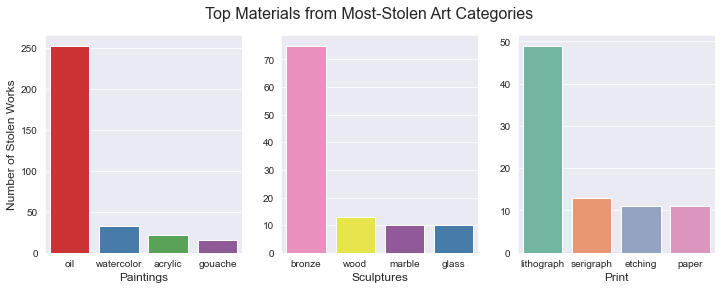

In [11]:
# create barplots for each crime category (paintings, sculpture, print)
sns.set_style("darkgrid")
fig, axes = plt.subplots(1,3)
fig.set(figwidth=12, figheight=4)
fig.suptitle('Top Materials from Most-Stolen Art Categories', fontsize='16')

sns.barplot(x=mini_counts['paintings'].index, ax=axes[0], y=mini_counts['paintings'].values, order=['oil', 'watercolor','acrylic','gouache'], palette = 'Set1')
axes[0].set_xlabel('Paintings', fontsize='12')
axes[0].set_ylabel('Number of Stolen Works', fontsize='12')

sns.barplot(x=mini_counts['sculpture'].index, ax=axes[1], y=mini_counts['sculpture'].values, order=['bronze','wood','marble','glass'], palette = 'Set1_r')
axes[1].set_xlabel('Sculptures', fontsize='12')
axes[1].set_ylabel('')

sns.barplot(x=mini_counts['print'].index, ax=axes[2], y=mini_counts['print'].values, order=['lithograph','serigraph','etching','paper'], palette = 'Set2')
axes[2].set_xlabel('Print', fontsize='12')
axes[2].set_ylabel('')

plt.show()